In [25]:
import matplotlib.pyplot as plt

import pandas as pd

import datetime as dt

import urllib.request, json

import os

import numpy as np

import tensorflow as tf # This code has been tested with TensorFlow 1.6

from sklearn.preprocessing import MinMaxScaler

In [47]:
df = pd.read_csv("0005.HK.csv")
df['log_rt1'] = np.log(df['Close']).diff()
df['log_rt2'] = df['log_rt1'].shift(1)
df['log_rt3'] = df['log_rt1'].shift(2)
df['log_rt4'] = df['log_rt1'].shift(3)
df['log_hc1'] = np.log(df['High']/df['Close'])
df['log_hc2'] = np.log(df['High']/df['Close'].shift(1))
df['log_hc3'] = np.log(df['High']/df['Close'].shift(2))
df['log_lag_hc2'] = np.log(df['High'].shift(1)/df['Close'].shift(1))
df['log_lag_hc3'] = np.log(df['High'].shift(2)/df['Close'].shift(2))
df['log_lag_hc3'] = np.log(df['High'].shift(3)/df['Close'].shift(3))
df['log_last_hc1'] = df['log_hc1'].shift(1)
df['log_last_hc2'] = df['log_hc2'].shift(1)
df['log_last_hc3'] = df['log_hc3'].shift(1)
df['log_lc1'] = np.log(df['Low']/df['Close'])
df['log_lc2'] = np.log(df['Low']/df['Close'].shift(1))
df['log_lc3'] = np.log(df['Low']/df['Close'].shift(2))
df['log_lag_lc2'] = np.log(df['Low'].shift(1)/df['Close'].shift(1))
df['log_lag_lc3'] = np.log(df['Low'].shift(2)/df['Close'].shift(2))
df['log_lag_lc3'] = np.log(df['Low'].shift(3)/df['Close'].shift(3))
df['log_last_lc1'] = df['log_lc1'].shift(1)
df['log_last_lc2'] = df['log_lc2'].shift(1)
df['log_last_lc3'] = df['log_lc3'].shift(1)
df['tr']=pd.concat([df['High'], df['Close'].shift(1)], axis=1).max(axis=1) \
           - pd.concat([df['Low'], df['Close'].shift(1)], axis=1).min(axis=1)
df['tr1'] = df['tr'].shift(1)
df['tr2'] = df['tr'].shift(2)
df['lc1'] = df['Close'].shift(1)
df['lc2'] = df['Close'].shift(2)
df['lc3'] = df['Close'].shift(3)

df = df.dropna().reset_index(drop=True)
df = df.head(len(df)-10)
df = df.reset_index(drop=True)

 

In [48]:
FullData=df[['Close']].values
print(FullData[len(df)-20:])
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
DataScaler = sc.fit(FullData)
Y=DataScaler.transform(FullData)
#X=FullData
#X = df.drop(columns=['Date','Open', 'High','Low','Close','Volume','log_rt1','log_hc1','log_hc2','log_hc3','log_lc1','log_lc2','log_lc3','tr'])
X = df[['lc1','lc2','lc3']]

#'lc1','lc2','lc3'
X = (X - X.min()) / (X.max() - X.min())
print('### After Normalization ###')
Y[len(df)-20:]
 

[[83.23461151]
 [85.68270111]
 [84.43466187]
 [84.60401154]
 [87.7228241 ]
 [88.56440735]
 [85.24757385]
 [74.7525177 ]
 [80.00004578]
 [84.50500488]
 [85.34658051]
 [86.63371277]
 [91.01024628]
 [93.05822754]
 [92.35891724]
 [93.15812683]
 [92.15911102]
 [92.15911102]
 [94.90640259]
 [94.706604  ]]
### After Normalization ###


array([[0.87388373],
       [0.90033588],
       [0.88685054],
       [0.8886804 ],
       [0.92237985],
       [0.93147335],
       [0.89563423],
       [0.78223284],
       [0.83893354],
       [0.88761061],
       [0.89670402],
       [0.91061177],
       [0.95790117],
       [0.98003006],
       [0.97247386],
       [0.9811095 ],
       [0.97031491],
       [0.97031491],
       [1.        ],
       [0.99784113]])

In [49]:
# split into samples
X_samples = list()
y_samples = list()
NumberOfRows = len(Y)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices
NumberOfFeatures = len(X.columns)
X=X.values
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumberOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = Y[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],TimeSteps, NumberOfFeatures)
print('\n#### Input Data shape ####')
print(X_data.shape)
# We do not reshape y as a 3D data  as i is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)
 


#### Input Data shape ####
(896, 10, 3)

#### Output Data shape ####
(896, 1)


In [36]:
# Choosing the number of testing data records
TestingRecords=150
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)

# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)


#### Training Data shape ####
(756, 10, 3)
(756, 1)

#### Testing Data shape ####
(150, 10, 3)
(150, 1)
[[0.51121775 0.513942   0.51159376]
 [0.53870627 0.51535122 0.513942  ]
 [0.52239954 0.543062   0.51535122]
 [0.54849036 0.52662342 0.543062  ]
 [0.54010385 0.55292521 0.52662342]
 [0.57465577 0.54447088 0.55292521]
 [0.59241791 0.57930217 0.54447088]
 [0.59662472 0.59720793 0.57930217]
 [0.58727625 0.60144876 0.59720793]
 [0.5952224  0.5920247  0.60144876]] -- [0.57341384]
[[0.53870627 0.51535122 0.513942  ]
 [0.52239954 0.543062   0.51535122]
 [0.54849036 0.52662342 0.543062  ]
 [0.54010385 0.55292521 0.52662342]
 [0.57465577 0.54447088 0.55292521]
 [0.59241791 0.57930217 0.54447088]
 [0.59662472 0.59720793 0.57930217]
 [0.58727625 0.60144876 0.59720793]
 [0.5952224  0.5920247  0.60144876]
 [0.61345183 0.60003509 0.5920247 ]] -- [0.58462708]


In [50]:
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)
 

Number of TimeSteps: 10
Number of Features: 3


In [51]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# Initialising the RNN
regressor = Sequential()
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'tanh', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'tanh', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'tanh', return_sequences=False ))
# Adding the output layer
regressor.add(Dense(units = 1))
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
##################################################
import time
# Measuring the time taken by the model to train
StartTime=time.time()
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')


Epoch 1/100


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0136
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014
Epoch 8/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014
Epoch 9/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 10/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 11/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 12/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 13/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012
Epoch 14/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 15/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

In [52]:
# Making predictions on test data

predicted_Price = regressor.predict(X_test)

predicted_Price = DataScaler.inverse_transform(predicted_Price)

 

# Getting the original price values for testing data

orig=y_test

orig=DataScaler.inverse_transform(y_test)

 

# Accuracy of the predictions

print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Accuracy: 93.19403022212938


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


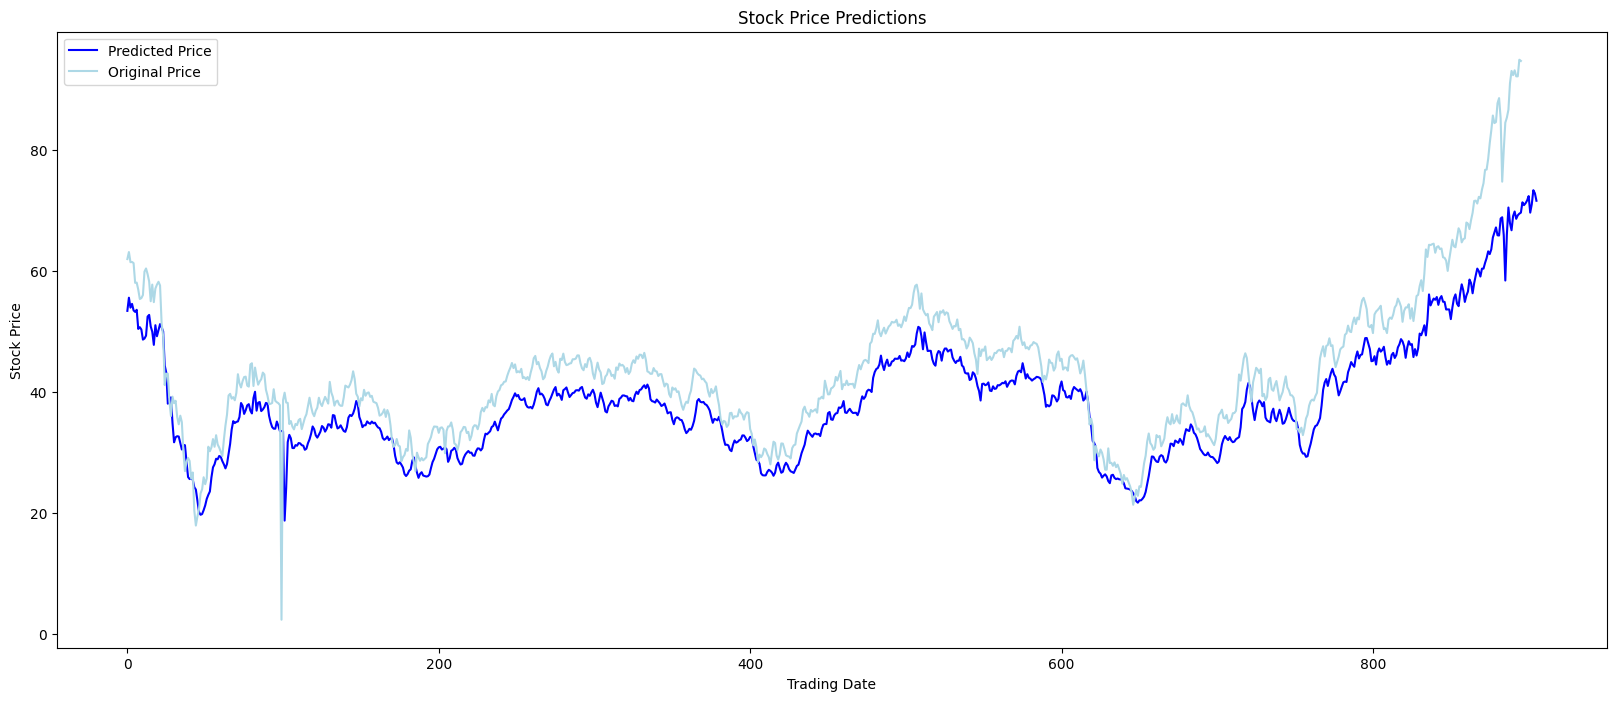

In [53]:
# Generating predictions on full data

TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))

TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

 

FullDataPredictions=np.append(TrainPredictions, TestPredictions)

FullDataOrig=FullData[TimeSteps:]

 

# plotting the full data

plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')

plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')

 

 

plt.title('Stock Price Predictions')

plt.xlabel('Trading Date')

plt.ylabel('Stock Price')

plt.legend()

fig=plt.gcf()

fig.set_figwidth(20)

fig.set_figheight(8)

plt.show()

In [54]:
regressor.save('v1.keras')